In [1]:
# import torch
# torch.set_default_dtype(torch.float64)
# import models

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# X0, V, pos = torch.load('data\X0.pt').to(device), torch.load('data\V.pt').to(device), torch.load('data\pos.pt').to(device)
# N = X0.shape[0]
# n = V.shape[1]
# # Data Preparation and Train-Test Splitting
# train_test_split = 0.8
# # X0_train = X0[:int(train_test_split*N)]
# X0_test = X0[int(train_test_split*N):]
# # V_train = V[:int(train_test_split*N)]
# V_test = V[int(train_test_split*N):]
# # pos_train = pos[:int(train_test_split*N)]
# pos_test = pos[int(train_test_split*N):]

# hidden_dims = [8, 16, 32, 64, 128]

# models = {d:[models.RNN(hidden_size=d) for _ in range(10)] for d in hidden_dims}
# model_weight_paths = {d:[f'hpc_results\hidden_dim_{d}_{i}.pth' for i in range(10)] for d in hidden_dims}

# for d in hidden_dims:
#     for i, model in enumerate(models[d]):
#         model.load_state_dict(torch.load(model_weight_paths[d][i]))
# X0_test.shape, V_test.shape, pos_test.shape

import torch
torch.set_default_dtype(torch.float64)
import models
from plane_math import immersion


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
n_trajectories = 10000
X0, V, pos = torch.load('data\X0.pt').to(device)[:n_trajectories], torch.load('data\V.pt').to(device)[:n_trajectories], torch.load('data\pos.pt').to(device)[:n_trajectories]
N = X0.shape[0]
n = V.shape[1]
# Data Preparation and Train-Test Splitting
train_test_split = 0.8
# X0_train = X0[:int(train_test_split*N)]
X0_test = X0[int(train_test_split*N):]
# V_train = V[:int(train_test_split*N)]
V_test = V[int(train_test_split*N):]
# pos_train = pos[:int(train_test_split*N)]
pos_test = pos[int(train_test_split*N):]

hidden_dims = [8, 16, 32, 64, 128]

pos_pred_naive = X0_test.unsqueeze(dim=1) + V_test.cumsum(dim=1)
# errors_naive = (immersion(pos_test[800:1000]) - immersion(pos_pred_naive[800:1000])).norm(dim=-1).mean(dim=0)
errors_naive = (immersion(pos_test) - immersion(pos_pred_naive)).norm(dim=-1).mean(dim=0)


########################################### Wyatt's variation on evaluation functions ###################################################
import gc
import matplotlib.pyplot as plt
from tqdm import tqdm

n_runs = 10
n_steps = V.shape[1]

# from surface_math import Surface

# surface = Surface()
# immersion = surface.immersion


def load_model(model_name, hidden_dim, run_idx):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    if model_name == 'RNN':
        model = models.RNN(hidden_size=hidden_dim)
    elif model_name == 'LSTM':
        model = models.ConditionalLSTM(hidden_size=hidden_dim)
    elif model_name == 'GRU':
        model = models.ConditionalGRU(hidden_size=hidden_dim)
    elif model_name == 'RNN_multilayer':
        model = models.RNN_multilayer(hidden_size=hidden_dim)
    # elif model_name == 'Transformer':
    #     model = models.TransformerWrapper('transformer_code/config.yaml', f'transformer_checkpoints/run_{run_idx}')
    #     return model.to(device)
    # elif model_name == 'RoFormer':
    #     model = models.RotaryTransformerWrapper('transformer_code/config.yaml', f'roformer_checkpoints/run_{run_idx}')
    #     return model.to(device)
    # elif model_name == 'Mamba':
    #     model = models.MambaWrapper('mamba_code/config.yaml', f'mamba_checkpoints/run_{run_idx}')
    #     return model.to(device)
    else:
        raise ValueError(f"Unknown model name: {model_name}")

    # Load weights for non-Transformer-type models
    model_path = f'model_weights/{model_name}/hidden_dim_{hidden_dim}_{run_idx}.pth'
    if not torch.cuda.is_available():
        model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
    else:
        model.load_state_dict(torch.load(model_path))

    return model.to(device)

    

def compute_errors(model):
    "Returns the mean errors for the model. Shape: (n_steps,)"
    
    # Compute the errors for a given model"
    mean_errors = torch.zeros(n_steps)
    model.eval()


    pos_pred = torch.zeros_like(pos_test)

    with torch.no_grad():
        # for i in range(n_steps):
        #     pos_pred[:,i] = model(x_0=X0_test, V=V_test[:,:i+1]).squeeze()
        pos_pred = model(x_0=X0_test, V=V_test)
    # print(f"pos_pred.shape = {pos_pred.shape}, pos_test.shape = {pos_test.shape}")
    mean_errors = (immersion(pos_test)-immersion(pos_pred)).norm(dim=-1).mean(dim=0)
    # mean_errors = ((pos_test)-(pos_pred)).norm(dim=-1).mean(dim=0) # No immersion needed for 3D data
    
    return mean_errors.cpu()

def compute_flops_inf(model):
    flops = FlopCountAnalysis(model, (X0, V))
    return (flops.total())


def evaluate(model_name, hidden_dim):
    errors = torch.zeros(n_runs, n_steps)

    for i in tqdm(range(n_runs)):
        # print(f"Evaluating {model_name}, run {i+1}/{n_runs}")

        # Load a single model
        # model = load_model(model_name, hidden_dim, i).float()
        model = load_model(model_name, hidden_dim, i)

        # Evaluate and store error
        errors[i] = compute_errors(model).cpu().detach()

        # Free memory
        del model
        torch.cuda.empty_cache()
        gc.collect()

    # Compute median error across runs
    medians = torch.median(errors, dim=0).values

    # Plot results
    for i in range(n_runs):
        plt.plot(errors[i], label=f'Run {i+1}', alpha=0.5)

    plt.plot(errors_naive.detach().cpu(), label='Naive Model', linestyle='--', color='black')
    plt.plot(medians, label='Medians', linestyle='--', color='red')
    plt.xlabel('Time Step')
    plt.ylabel('Avg Error')
    plt.title(f'{model_name} with hidden dim {hidden_dim}')
    plt.legend()
    # plt.savefig('Torus_' + model_name + '_avgerror.png')
    # plt.clf()  # Clear figure for the next plot
    plt.show()

    # Metrics
    E_10 = medians[9]
    E_100 = medians[99]
    # E_40 = medians[49]
    #flops_inf = compute_flops_inf(load_model(model_name, hidden_dim, 0))

    return {
        'model_name': model_name,
        'hidden_dim': hidden_dim,
        'E_10': E_10,
        'E_100': E_100,
        'flops_inf': 'NaN'
    }

C:\Users\Sathya\AppData\Local\Temp\ipykernel_11752\956389373.py:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  X0, V, pos = torch.load('data\X0.pt').to(device)[:n_traject

In [2]:
errors_naive[9], errors_naive[99]

(tensor(0.), tensor(0.))

In [14]:
pos_test.shape, pos_pred.shape

(torch.Size([2000, 100, 2]), torch.Size([2000, 100, 2]))

In [3]:
from fvcore.nn import FlopCountAnalysis
import matplotlib.pyplot as plt
from plane_math import immersion

n_runs = 10
n_steps = V.shape[1]

def load_models(model_name, hidden_dim):
    if model_name == 'RNN':
        models_ = [models.RNN(hidden_size=hidden_dim) for _ in range(n_runs)]
    elif model_name == 'LSTM':
        models_ = [models.ConditionalLSTM(hidden_size=hidden_dim) for _ in range(n_runs)]
    elif model_name == 'GRU':
        models_ = [models.ConditionalGRU(hidden_size=hidden_dim) for _ in range(n_runs)]
    elif model_name == 'RNN_multilayer':
        models_ = [models.RNN_multilayer(hidden_size=hidden_dim) for _ in range(n_runs)]

        
    model_weight_paths = [f'model_weights\{model_name}\hidden_dim_{hidden_dim}_{i}.pth' for i in range(n_runs)]

    if torch.cuda.is_available() == False:
        for i, model in enumerate(models_):
            # print(f"Model keys = {model.state_dict().keys()}, Model weight keys = {torch.load(model_weight_paths[i], map_location=torch.device('cpu')).keys()}")
            model.load_state_dict(torch.load(model_weight_paths[i], map_location=torch.device('cpu')))
    else:
        for i, model in enumerate(models_):
            model.load_state_dict(torch.load(model_weight_paths[i])) 
    
    return models_

def compute_errors(model):
    "Returns the mean errors for the model. Shape: (n_steps,)"
    
    # Compute the errors for a given model"
    mean_errors = torch.zeros(n_steps)
    model.eval()


    pos_pred = torch.zeros_like(pos_test)

    with torch.no_grad():
        # for i in range(n_steps):
        #     pos_pred[:,i] = model(x_0=X0_test, V=V_test[:,:i+1]).squeeze()
        pos_pred = model(x_0=X0_test, V=V_test)
    # print(f"pos_pred.shape = {pos_pred.shape}, pos_test.shape = {pos_test.shape}")
    mean_errors = (immersion(pos_test)-immersion(pos_pred)).norm(dim=-1).mean(dim=0)
    
    return mean_errors

def compute_flops_inf(model):
    flops = FlopCountAnalysis(model, (X0, V))
    return (flops.total())


def evaluate(model_name, hidden_dim):
    # Load the model
    models_ = load_models(model_name, hidden_dim)

    # Compute outputs and errors
    errors = torch.zeros(n_runs, n_steps)
    for i in range(n_runs):
        model = models_[i]
        errors[i] = compute_errors(model)

    # Compute medians of all models
    medians = torch.median(errors, dim=0).values

    # Plot all models together
    for i in range(n_runs):
        plt.plot(errors[i], label=f'Run {i+1}', alpha=0.5)
    
    plt.plot(errors_naive, label='Naive Model', linestyle='--', color='black')
    plt.plot(medians, label='Medians', linestyle='--', color='red')
    plt.xlabel('Time Step')
    plt.ylabel('Avg Error')
    plt.title(f'{model_name} with hidden dim {hidden_dim}')
    plt.legend()



    # Compute E_10, E_100
    E_10 = medians[9]
    E_100 = medians[99]

    # Compute Flops Inf, Flops BP
    flops_inf = compute_flops_inf(models_[0])
    # flops_bp = compute_flops_bp(models[0])

    return {'model_name': model_name, 'hidden_dim': hidden_dim, 'E_10': E_10, 'E_100': E_100, 'flops_inf': flops_inf}

# RNN

C:\Users\Sathya\AppData\Local\Temp\ipykernel_9688\2214425744.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_weight_paths[i], map

{'model_name': 'RNN',
 'hidden_dim': 8,
 'E_10': tensor(0.0055),
 'E_100': tensor(0.0785),
 'flops_inf': 16160000}

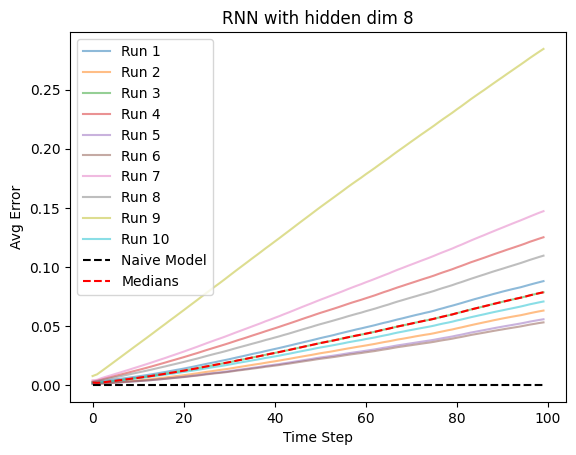

In [6]:
evaluate('RNN', 8)

C:\Users\Sathya\AppData\Local\Temp\ipykernel_9688\2214425744.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_weight_paths[i], map

{'model_name': 'RNN',
 'hidden_dim': 16,
 'E_10': tensor(0.0053),
 'E_100': tensor(0.0507),
 'flops_inf': 32320000}

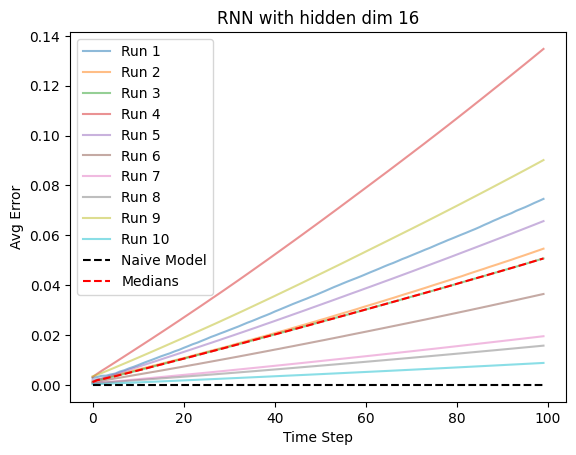

In [7]:
evaluate('RNN', 16)

C:\Users\Sathya\AppData\Local\Temp\ipykernel_9688\2214425744.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_weight_paths[i], map

{'model_name': 'RNN',
 'hidden_dim': 32,
 'E_10': tensor(0.0054),
 'E_100': tensor(0.0498),
 'flops_inf': 64640000}

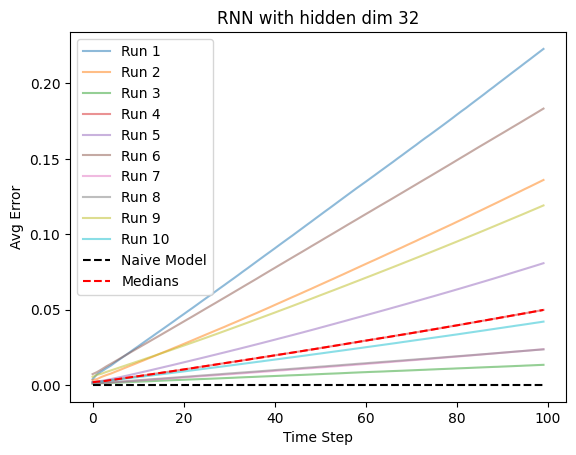

In [8]:
evaluate('RNN', 32)

C:\Users\Sathya\AppData\Local\Temp\ipykernel_9688\2214425744.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_weight_paths[i], map

{'model_name': 'RNN',
 'hidden_dim': 64,
 'E_10': tensor(0.0018),
 'E_100': tensor(0.0127),
 'flops_inf': 129280000}

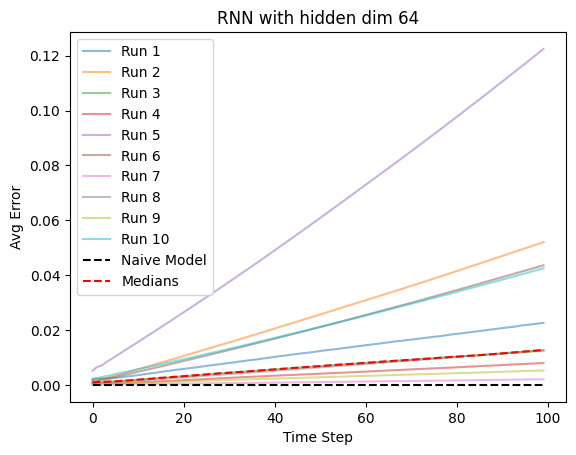

In [9]:
evaluate('RNN', 64)

C:\Users\Sathya\AppData\Local\Temp\ipykernel_9688\2214425744.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_weight_paths[i], map

{'model_name': 'RNN',
 'hidden_dim': 128,
 'E_10': tensor(0.0033),
 'E_100': tensor(0.0289),
 'flops_inf': 258560000}

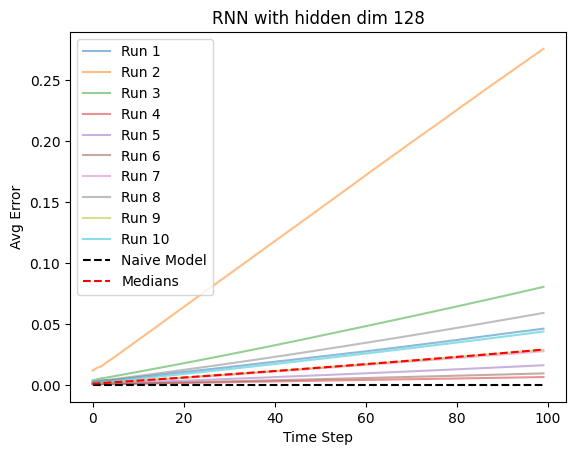

In [10]:
evaluate('RNN', 128)

# LSTM

C:\Users\Sathya\AppData\Local\Temp\ipykernel_9688\2214425744.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_weight_paths[i], map

{'model_name': 'LSTM',
 'hidden_dim': 8,
 'E_10': tensor(0.0084),
 'E_100': tensor(0.2492),
 'flops_inf': 16160000}

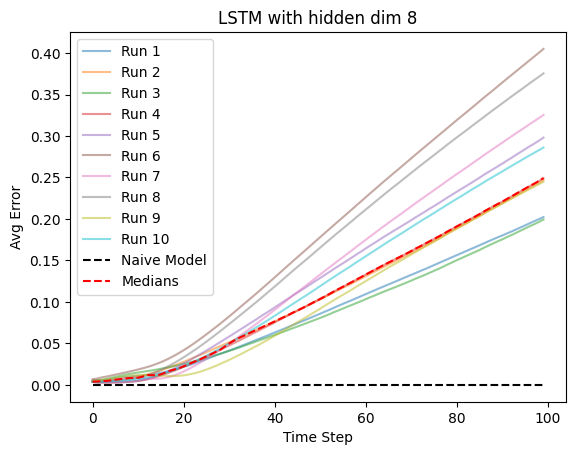

In [11]:
evaluate('LSTM', 8)

C:\Users\Sathya\AppData\Local\Temp\ipykernel_9688\2214425744.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_weight_paths[i], map

{'model_name': 'LSTM',
 'hidden_dim': 16,
 'E_10': tensor(0.0069),
 'E_100': tensor(0.1953),
 'flops_inf': 32320000}

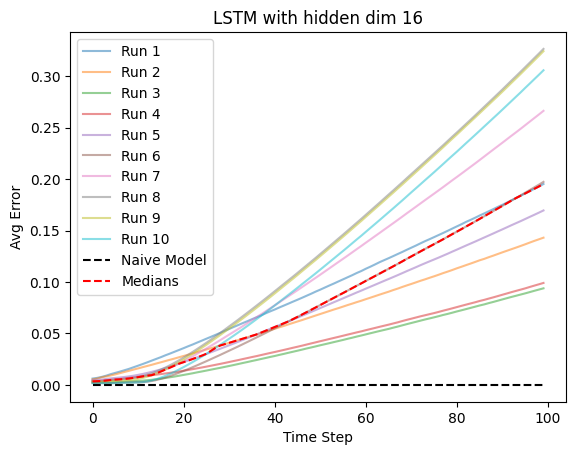

In [12]:
evaluate('LSTM', 16)

C:\Users\Sathya\AppData\Local\Temp\ipykernel_9688\2214425744.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_weight_paths[i], map

{'model_name': 'LSTM',
 'hidden_dim': 32,
 'E_10': tensor(0.0037),
 'E_100': tensor(0.1658),
 'flops_inf': 64640000}

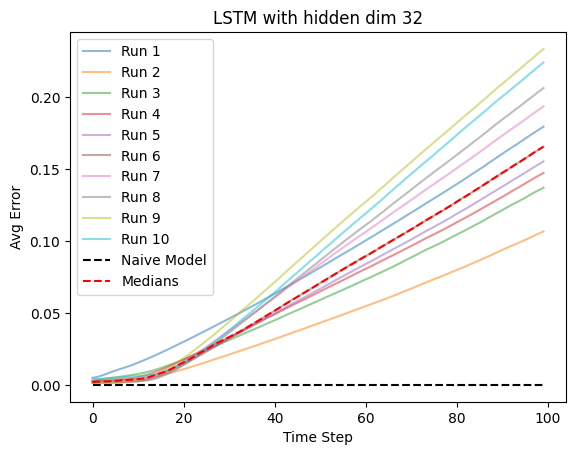

In [13]:
evaluate('LSTM', 32)

C:\Users\Sathya\AppData\Local\Temp\ipykernel_12712\2214425744.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_weight_paths[i], ma

{'model_name': 'LSTM',
 'hidden_dim': 64,
 'E_10': tensor(0.0063),
 'E_100': tensor(0.1217),
 'flops_inf': 129280000}

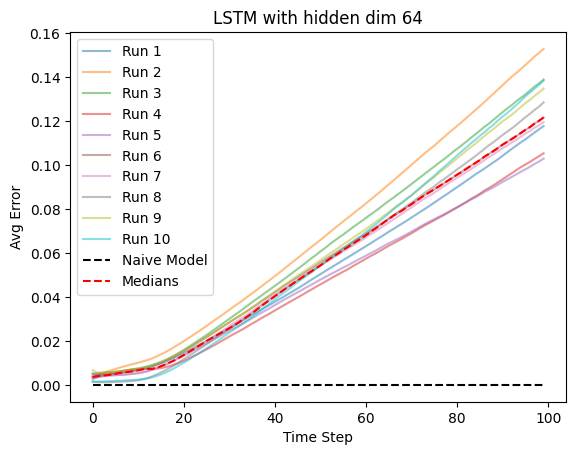

In [3]:
evaluate('LSTM', 64)

  0%|          | 0/10 [00:00<?, ?it/s]C:\Users\Sathya\AppData\Local\Temp\ipykernel_11752\956389373.py:95: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict

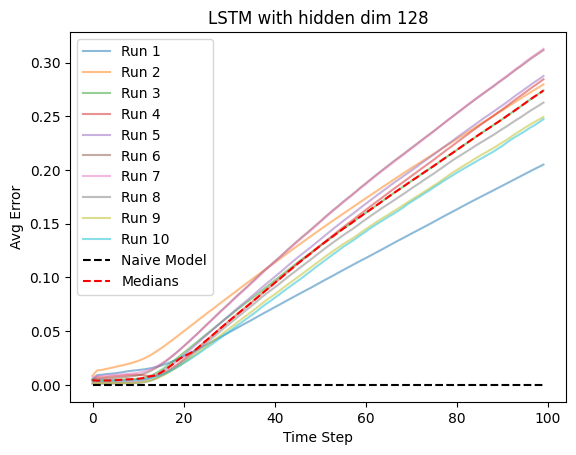

{'model_name': 'LSTM',
 'hidden_dim': 128,
 'E_10': tensor(0.0054),
 'E_100': tensor(0.2741),
 'flops_inf': 'NaN'}

In [5]:
evaluate('LSTM', 128)

# GRU

C:\Users\Sathya\AppData\Local\Temp\ipykernel_12712\2214425744.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_weight_paths[i], ma

{'model_name': 'GRU',
 'hidden_dim': 8,
 'E_10': tensor(0.0036),
 'E_100': tensor(0.3503),
 'flops_inf': 16160000}

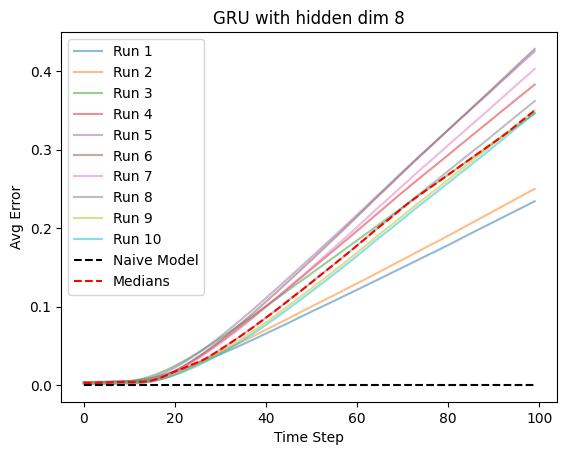

In [4]:
evaluate('GRU', 8)

C:\Users\Sathya\AppData\Local\Temp\ipykernel_12712\2214425744.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_weight_paths[i], ma

{'model_name': 'GRU',
 'hidden_dim': 16,
 'E_10': tensor(0.0022),
 'E_100': tensor(0.1954),
 'flops_inf': 32320000}

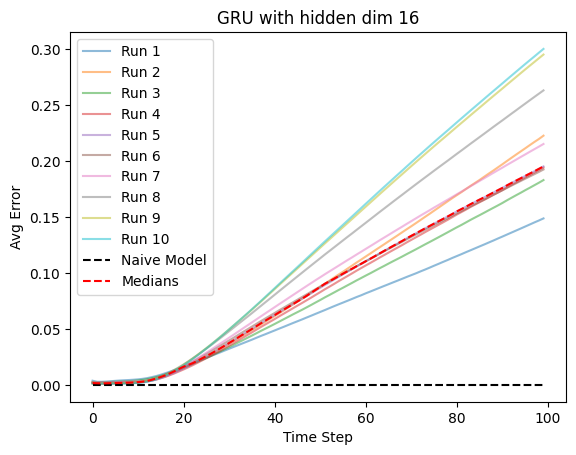

In [5]:
evaluate('GRU', 16)

C:\Users\Sathya\AppData\Local\Temp\ipykernel_12712\2214425744.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_weight_paths[i], ma

{'model_name': 'GRU',
 'hidden_dim': 32,
 'E_10': tensor(0.0021),
 'E_100': tensor(0.1029),
 'flops_inf': 64640000}

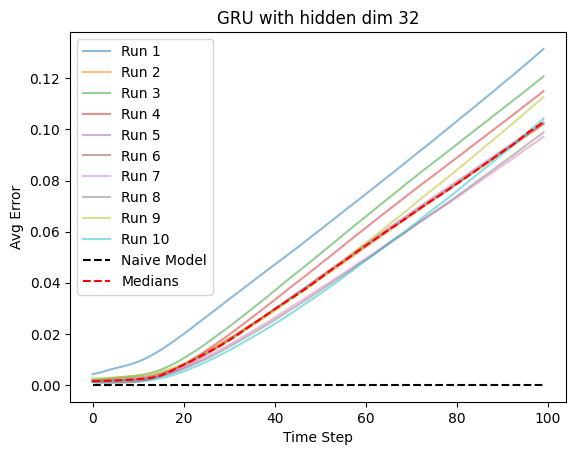

In [6]:
evaluate('GRU', 32)

C:\Users\Sathya\AppData\Local\Temp\ipykernel_12712\2214425744.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_weight_paths[i], ma

{'model_name': 'GRU',
 'hidden_dim': 64,
 'E_10': tensor(0.0012),
 'E_100': tensor(0.1862),
 'flops_inf': 129280000}

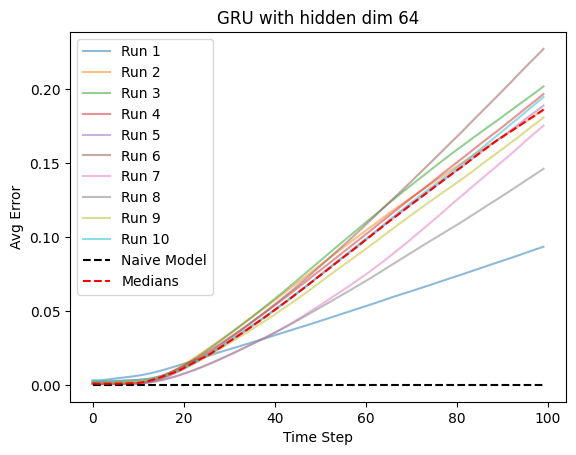

In [7]:
evaluate('GRU', 64)

  0%|          | 0/10 [00:00<?, ?it/s]C:\Users\Sathya\AppData\Local\Temp\ipykernel_11752\956389373.py:95: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict

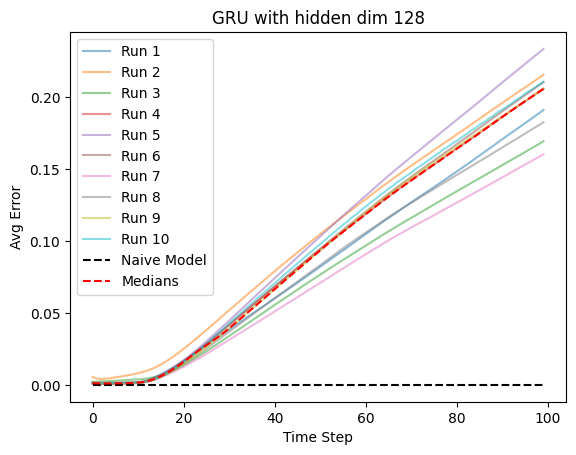

{'model_name': 'GRU',
 'hidden_dim': 128,
 'E_10': tensor(0.0013),
 'E_100': tensor(0.2057),
 'flops_inf': 'NaN'}

In [4]:
evaluate('GRU', 128)

# 2-layer RNN

C:\Users\Sathya\AppData\Local\Temp\ipykernel_26792\2214425744.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_weight_paths[i], ma

{'model_name': 'RNN_multilayer',
 'hidden_dim': 8,
 'E_10': tensor(0.0123),
 'E_100': tensor(0.5897),
 'flops_inf': 16320000}

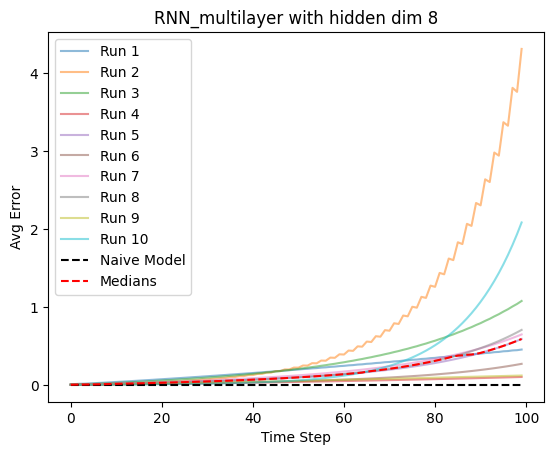

In [9]:
evaluate('RNN_multilayer', 8)

C:\Users\Sathya\AppData\Local\Temp\ipykernel_26792\2214425744.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_weight_paths[i], ma

{'model_name': 'RNN_multilayer',
 'hidden_dim': 16,
 'E_10': tensor(0.0033),
 'E_100': tensor(0.0223),
 'flops_inf': 32640000}

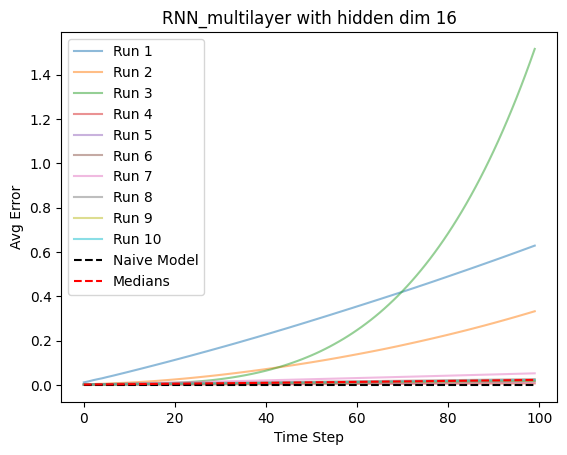

In [10]:
evaluate('RNN_multilayer', 16)

C:\Users\Sathya\AppData\Local\Temp\ipykernel_26792\2214425744.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_weight_paths[i], ma

{'model_name': 'RNN_multilayer',
 'hidden_dim': 32,
 'E_10': tensor(0.0035),
 'E_100': tensor(0.0594),
 'flops_inf': 65280000}

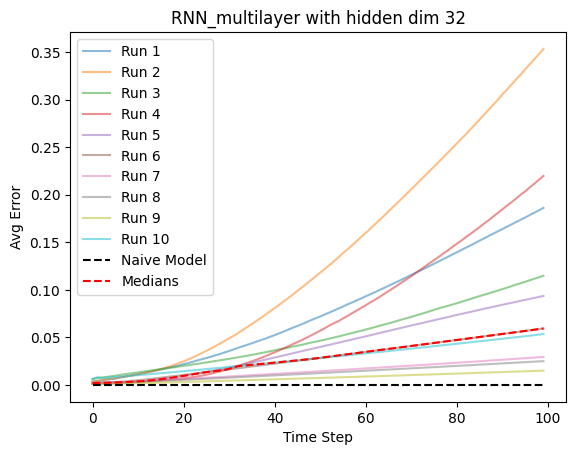

In [11]:
evaluate('RNN_multilayer', 32)

C:\Users\Sathya\AppData\Local\Temp\ipykernel_26792\2214425744.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_weight_paths[i], ma

{'model_name': 'RNN_multilayer',
 'hidden_dim': 64,
 'E_10': tensor(0.0067),
 'E_100': tensor(0.0465),
 'flops_inf': 130560000}

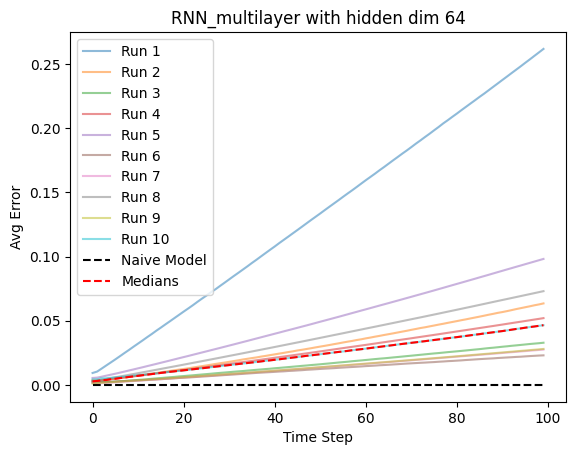

In [12]:
evaluate('RNN_multilayer', 64)

  0%|          | 0/10 [00:00<?, ?it/s]C:\Users\Sathya\AppData\Local\Temp\ipykernel_11752\956389373.py:95: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict

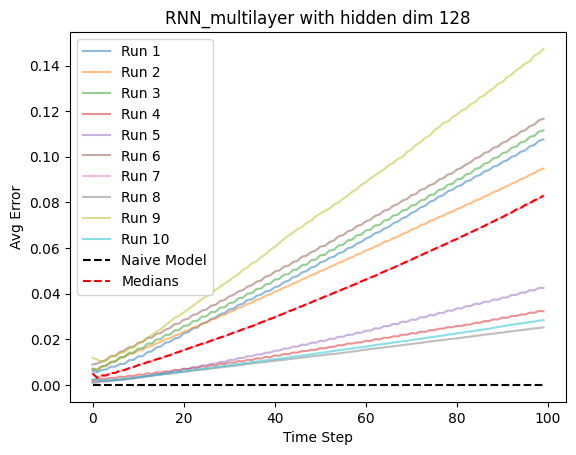

{'model_name': 'RNN_multilayer',
 'hidden_dim': 128,
 'E_10': tensor(0.0078),
 'E_100': tensor(0.0830),
 'flops_inf': 'NaN'}

In [3]:
evaluate('RNN_multilayer', 128)

# Other

In [ ]:
model = models[8][0]
model.eval()
n_steps = V.shape[1]

pos_pred = torch.zeros_like(pos_test)
with torch.no_grad():
    for i in range(n_steps):
        pos_pred[:,i] = model(x_0=X0_test, V=V_test[:,:i+1]).squeeze()

(pos_test[:,0]-pos_pred[:,0]).norm(dim=-1).mean()

tensor(0.0022)

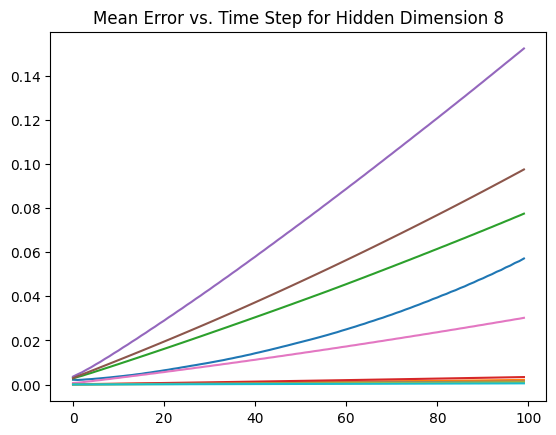

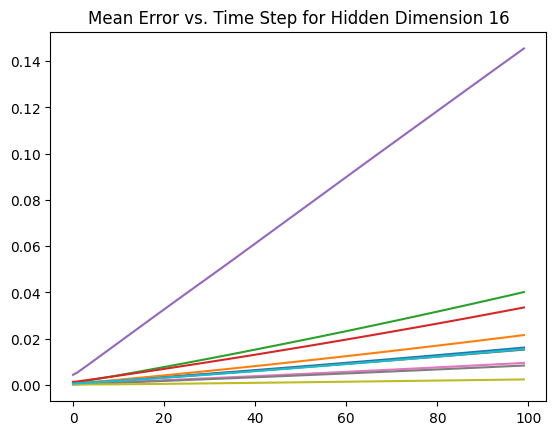

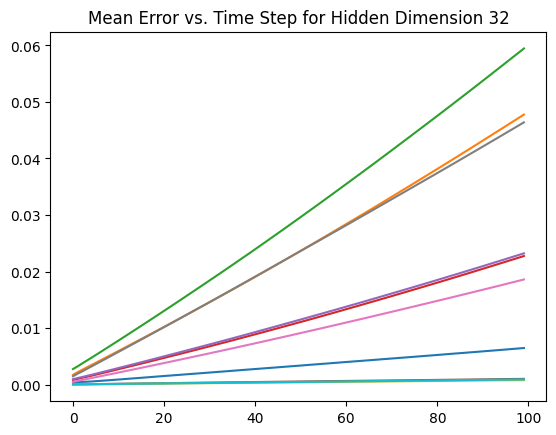

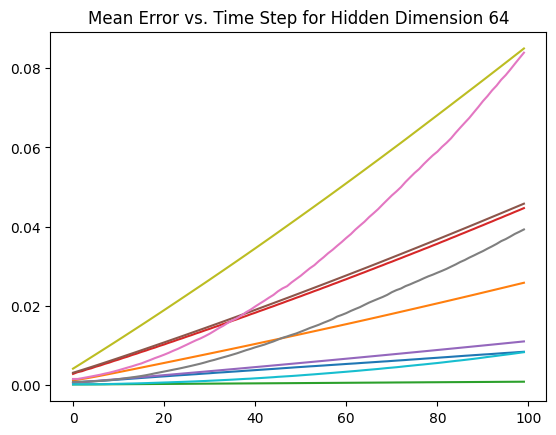

In [ ]:
import matplotlib.pyplot as plt

for d in hidden_dims:
    for run in range(10):
        model = models[d][run]
        model.eval()
        n_steps = V.shape[1]

        pos_pred = torch.zeros_like(pos_test)
        with torch.no_grad():
            for i in range(n_steps):
                pos_pred[:,i] = model(x_0=X0_test, V=V_test[:,:i+1]).squeeze()

        (pos_test[:,0]-pos_pred[:,0]).norm(dim=-1).mean()
        mean_errors = (pos_test-pos_pred).norm(dim=-1).mean(dim=0)
        plt.plot(mean_errors)
    plt.title(f'Mean Error vs. Time Step for Hidden Dimension {d}')
    plt.show()

In [32]:
pos_pred

tensor([[[ 0.4225, -0.0594],
         [ 0.3375, -0.0823],
         [ 0.3388, -0.1706],
         ...,
         [ 0.5907, -0.2654],
         [ 0.6375, -0.2928],
         [ 0.6318, -0.2634]],

        [[ 0.1917,  0.4015],
         [ 0.1754,  0.4066],
         [ 0.1891,  0.4074],
         ...,
         [ 0.0026,  0.3897],
         [-0.0676,  0.3484],
         [-0.0236,  0.4108]],

        [[ 0.5436, -0.3787],
         [ 0.5024, -0.3963],
         [ 0.5519, -0.4136],
         ...,
         [ 0.5519, -0.6225],
         [ 0.6034, -0.6495],
         [ 0.6406, -0.6274]],

        ...,

        [[ 0.5504,  0.3651],
         [ 0.5400,  0.3831],
         [ 0.5488,  0.4077],
         ...,
         [ 0.4045, -0.0135],
         [ 0.3417,  0.0438],
         [ 0.2982,  0.0760]],

        [[ 0.0741, -0.5243],
         [ 0.1146, -0.5600],
         [ 0.2018, -0.6011],
         ...,
         [ 0.9047, -0.5683],
         [ 0.8316, -0.5940],
         [ 0.8790, -0.5461]],

        [[-0.0370,  0.4477],
       